In [19]:
import os
import numpy as np
import pandas as pd
import warnings
from tqdm import tqdm
import joblib
import keras
import matplotlib.pyplot as plt


#from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import f1_score
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, BatchNormalization, LSTM, Bidirectional, SimpleRNN

In [26]:
from src.preprocessor import data_reader, clean_string, data_prep
from src.nn.params import f1

In [21]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth',None)
tqdm.pandas()

In [22]:
data_dir =  os.path.join(os.path.sep.join(os.getcwd().split(os.path.sep)[:-1]), "data")

In [23]:
df_train = pd.read_csv(os.path.join(data_dir,"dataset.csv")).loc[lambda x: x["emotion"] != "neutral"]
df_test = pd.read_csv(os.path.join(data_dir,"test_set.csv"))

In [24]:
df_train.head(5)

,sentence,emotion
0,I just do not know i feel like i am just way to paranoid i want to trust but its hard been hurt way to many times .,fear
1,I want to be with him so bad that i feel i am being tortured right now .,anger
2,I spent most of the day alone and several hours feeling unimportant because we were going to hang out together but nothing happened .,sadness
3,I am feeling so horny that i will make love to you if you are here and let you shoot in me hoping that my egg and your sperm can unite .,happiness
4,I do love feeling all clever when i do understand what they are saying .,happiness


In [25]:
# Cleaning
df_train.drop_duplicates(keep='first',inplace=True)
df_train.dropna(inplace=True)
df_train["emotion"].value_counts()

emotion
happiness    224422
sadness      143454
anger         77918
fear          59695
surprise      35989
disgust        5550
Name: count, dtype: int64

In [27]:
tokenizer = Tokenizer()
label_encoder = LabelEncoder()
pd.set_option('display.max_colwidth',None)
dfs, keys = data_reader('data')

TypeError: __init__() missing 1 required positional argument: 'string'

In [103]:
for i, variable_name in enumerate(keys):
    globals()[variable_name] = dfs[i]

In [104]:
print(f'all_datasets: {all_datasets.shape}')
print(f'all_datasets_stem_no_stopwords  : {all_datasets_stem_no_stopwords.shape}')
print(f'all_datasets_evenly_distributed : {all_datasets_evenly_distributed.shape}')

print(f'all_datasets_without_reddit : {all_datasets_without_reddit.shape}')
print(f'all_datasets_without_reddit_stem_no_stopwords : {all_datasets_without_reddit_stem_no_stopwords.shape}')

print(f'all_datasets_without_reddit_evenly_distributed : {all_datasets_without_reddit_evenly_distributed.shape}')
print(f'all_datasets_without_reddit_evenly_distributed_stem_no_stopwords : {all_datasets_without_reddit_evenly_distributed_stem_no_stopwords.shape}')

all_datasets: (646214, 2)
all_datasets_stem_no_stopwords  : (646214, 2)
all_datasets_evenly_distributed : (163374, 2)
all_datasets_without_reddit : (646214, 2)
all_datasets_without_reddit_stem_no_stopwords : (493698, 2)
all_datasets_without_reddit_evenly_distributed : (163374, 2)
all_datasets_without_reddit_evenly_distributed_stem_no_stopwords : (89352, 2)


In [105]:
df = df_old
y_true['sentence'] = y_true['sentence'].progress_apply(lambda x: clean_string(x,stem="None"))

100%|██████████| 1436/1436 [00:00<00:00, 8294.30it/s]


In [106]:
texts = df["sentence"].tolist()
labels = df["emotion"].tolist()

# Fit tokenizer on the texts to create word indices
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to ensure uniform length
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Encode the string labels to integers
labels = label_encoder.fit_transform(labels)

# One-hot encode the labels
one_hot_labels = keras.utils.to_categorical(labels)     

In [107]:
# Split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(padded_sequences,
                                                one_hot_labels,
                                                test_size=0.2,
                                                random_state=42)

In [108]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [109]:
#Simple model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=6, input_length=max_length))
model.add(Flatten())
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.5)) 
model.add(BatchNormalization()) 

model.add(Dense(units=len(one_hot_labels[0]), activation="softmax"))

In [110]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy",f1])
H = model.fit(xtrain, ytrain,
              epochs=10,
              batch_size=32,
              validation_data=(xtest, ytest))

Epoch 1/10
13676/13676 [==============================] - 92s 7ms/step - loss: 0.4305 - accuracy: 0.8575 - f1: 0.8552 - val_loss: 0.2805 - val_accuracy: 0.9030 - val_f1: 0.9116
Epoch 2/10
13676/13676 [==============================] - 68s 5ms/step - loss: 0.3014 - accuracy: 0.8986 - f1: 0.9049 - val_loss: 0.2620 - val_accuracy: 0.9093 - val_f1: 0.9165
Epoch 3/10
13676/13676 [==============================] - 71s 5ms/step - loss: 0.2702 - accuracy: 0.9080 - f1: 0.9135 - val_loss: 0.2564 - val_accuracy: 0.9118 - val_f1: 0.9171
Epoch 4/10
13676/13676 [==============================] - 70s 5ms/step - loss: 0.2498 - accuracy: 0.9143 - f1: 0.9194 - val_loss: 0.2580 - val_accuracy: 0.9125 - val_f1: 0.9183
Epoch 5/10
13676/13676 [==============================] - 71s 5ms/step - loss: 0.2358 - accuracy: 0.9192 - f1: 0.9238 - val_loss: 0.2541 - val_accuracy: 0.9147 - val_f1: 0.9206
Epoch 6/10
13676/13676 [==============================] - 67s 5ms/step - loss: 0.2253 - accuracy: 0.9225 - f1: 0.92

In [111]:
model.evaluate(xtest,ytest)

3419/3419 [==============================] - 6s 2ms/step - loss: 0.2602 - accuracy: 0.9161 - f1: 0.9217


[0.2602151930332184, 0.9161380529403687, 0.9216707944869995]

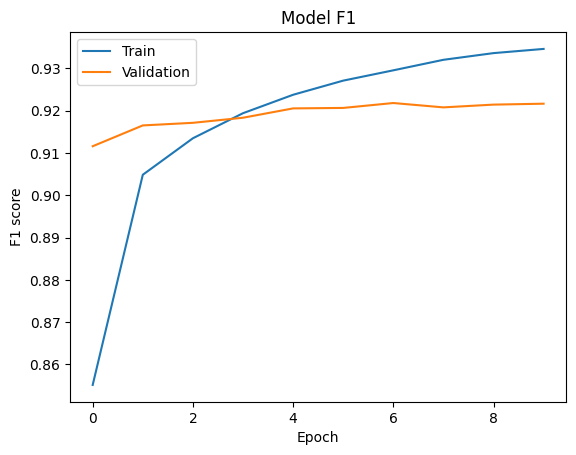

In [112]:
# Plot training & validation f1/
plt.plot(H.history['f1'])
plt.plot(H.history['val_f1'])
plt.title('Model F1')
plt.ylabel('F1 score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [113]:
example_text = df_test['sentence'].sample().iloc[0]

# Preprocess the input text
test_sequence = tokenizer.texts_to_sequences([example_text])
padded_input_sequence = pad_sequences(test_sequence, maxlen=max_length)

y_pred = model.predict(padded_input_sequence)
predicted_label = label_encoder.inverse_transform([np.argmax(y_pred[0])])

print(example_text)
print(predicted_label)

1/1 [==============================] - 0s 63ms/step
It makes me furious when my roomates forgets to flush.
['anger']


In [114]:
text = y_true['sentence']
predictions = y_true.copy()

test_sequences = tokenizer.texts_to_sequences(text)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length)

y_preds = model.predict(padded_test_sequences)
predicted_labels = label_encoder.inverse_transform([np.argmax(pred) for pred in y_preds])

predictions['emotion'] = predicted_labels
predictions['emotion'].value_counts()

45/45 [==============================] - 0s 1ms/step


emotion
happiness    439
anger        310
sadness      227
fear         213
surprise     187
disgust       60
Name: count, dtype: int64

In [115]:
assert predictions.shape == y_true.shape

In [116]:
f1_score(predictions['emotion'], y_true['emotion'], average='weighted')

0.6503999684885589

In [ ]:
def save_sub_model(model,sub_name, model_name):
    predictions[['id','emotion']].to_csv(f'submissions/{sub_name}.csv',index=False)
    joblib.dump(model,f'models/{model_name}.keras')
    return predictions[['id','emotion']]

In [ ]:
#submission = save_sub_model(model,'rnn_emotion_detection_1','rnn_20_03_1')